In [ ]:
# This is the template for the submission. If you want, you can develop your algorithm in a regular Python script and copy the code here for submission.

# Team members (e-mail, legi):
# zhisun@ethz.ch, 22-958-227
# enjcao@ethz.ch, 22-942-700
# yifzhou@ethz.ch, 22-940-381


""" categories (weight 0.1 for cycle, 0.05 for each of other three activities):
standing still: 0 or 1
walk: 0 or 1
run: 0 or 1
cycle: 0 or 1 """

' categories (weight 0.1 for cycle, 0.05 for each of other three activities):\nstanding still: 0 or 1\nwalk: 0 or 1\nrun: 0 or 1\ncycle: 0 or 1 '

In [1]:
import pandas as pd
import math
from Lilygo.Recording import Recording
from Lilygo.Dataset import Dataset
from os import listdir
from os.path import isfile, join
from math import sqrt
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

In [38]:
# Get the path of all traces
dir_data = 'E:\\Sunzhichao\\ETHz\\2223Spring\\Mobile_Health\\data\\'
dir_data = '.\\data\\'
dir_traces = dir_data + 'train\\'
dir_labels = dir_data + 'labels\\'
dir_loaded = dir_data + 'Loaded_data\\'
filenames = [join(dir_traces, f) for f in listdir(dir_traces) if isfile(join(dir_traces, f))]
data_win_counts = np.load(dir_loaded + 'train_data_count_w3.npy')
activity_labels = np.load(dir_loaded + 'train_activity_label_w3.npy')
filenames.sort()


In [52]:
file_id = 162
filename = filenames[file_id]
trace = Recording(filename, no_labels=False, mute=True)
data_win_count = data_win_counts[file_id]
sampling_rate = 200
std_win = 3 #s
window_size = round(std_win*sampling_rate)

# plot
title = "data: " + filename.split('\\')[-1] + " activities: " + str(trace.labels['activities']), " path_idx: " + str(trace.labels['path_idx']), " board_loc: " + str(trace.labels['board_loc'])


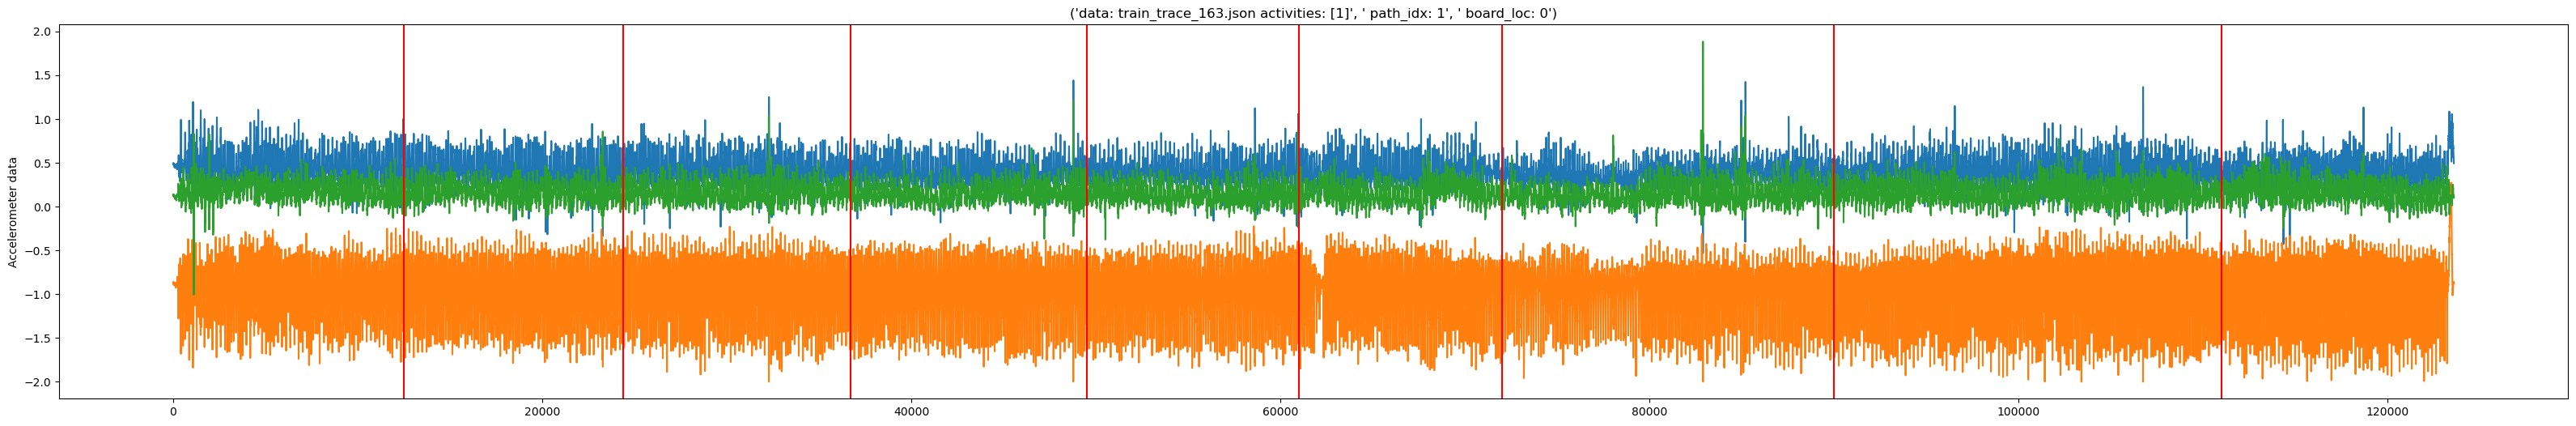

In [53]:

fig, ax = plt.subplots(1, 1, figsize=(40, 6), sharex=True)
ax.set_title(title)
ax.plot(trace.data['ax'].values)
ax.plot(trace.data['ay'].values)
ax.plot(trace.data['az'].values)
ax.set_ylabel('Accelerometer data')
ax.axvline(12500, color = 'r')
ax.axvline(24400, color = 'r')
ax.axvline(36700, color = 'r')
ax.axvline(49500, color = 'r')
ax.axvline(61000, color = 'r')
ax.axvline(72000, color = 'r')
ax.axvline(90000, color = 'r')
ax.axvline(111000, color = 'r')


# ax[0].set_title(title)
# ax[0].plot(trace.data['ax'].values)
# ax[0].plot(trace.data['ay'].values)
# ax[0].plot(trace.data['az'].values)
# ax[0].set_ylabel('Accelerometer data')
# ax[0].axvline(105900, color = 'r')
# ax[0].axvline(113900, color = 'r')
# ax[1].plot(trace.data['gx'].values)
# ax[1].plot(trace.data['gy'].values)
# ax[1].plot(trace.data['gz'].values)
# ax[1].axvline(105900, color = 'r')
# ax[1].axvline(113900, color = 'r')
# ax[1].set_ylabel('Gero data')




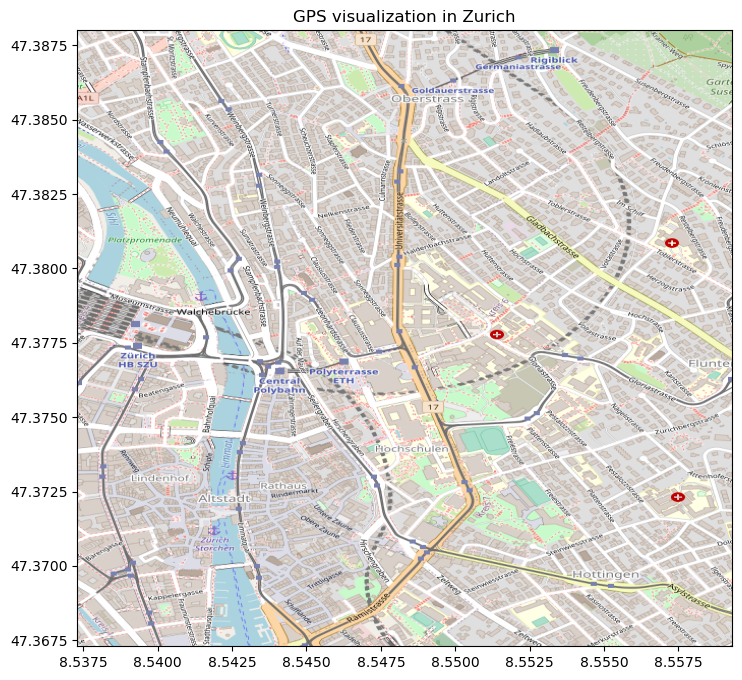

In [47]:
# Trace must contain gps data
# assert('latitude' in trace.data and 'longitude' in trace.data)

plot_map_zurich = True

# Visualize the path of the trace
fig, ax = plt.subplots(figsize = (12,8))

# # central
# ax.scatter(8.5441, 47.3768, zorder=1, alpha= 0.3, c='r', s=500)
# # Main building
# ax.scatter(8.5486, 47.3766, zorder=1, alpha= 0.3, c='r', s=300)
# # P2 End/P3 start
# ax.scatter(8.5415, 47.3785, zorder=1, alpha= 0.3, c='r', s=300)
# # P4 End
# ax.scatter(8.5418, 47.3770, zorder=1, alpha= 0.3, c='r', s=300)
# # P1 corner
# ax.scatter(8.5467, 47.3782, zorder=1, alpha= 0.3, c='r', s=300)
# path
ax.scatter(trace.data['longitude'].values[101500:], trace.data['latitude'].values[101500:], zorder=1, alpha= 0.9, c='b', s=10)
ax.set_title('Visualization of the path')

if plot_map_zurich:
    # Bounding coordinates for map
    BBox = (8.5373,8.5593,
            47.3673, 47.3880)
    # Load map of Zurich
    ruh_m = plt.imread('mapzurich.png')
    ax.set_title('GPS visualization in Zurich')
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    ax.imshow(ruh_m, zorder=0, extent = BBox)

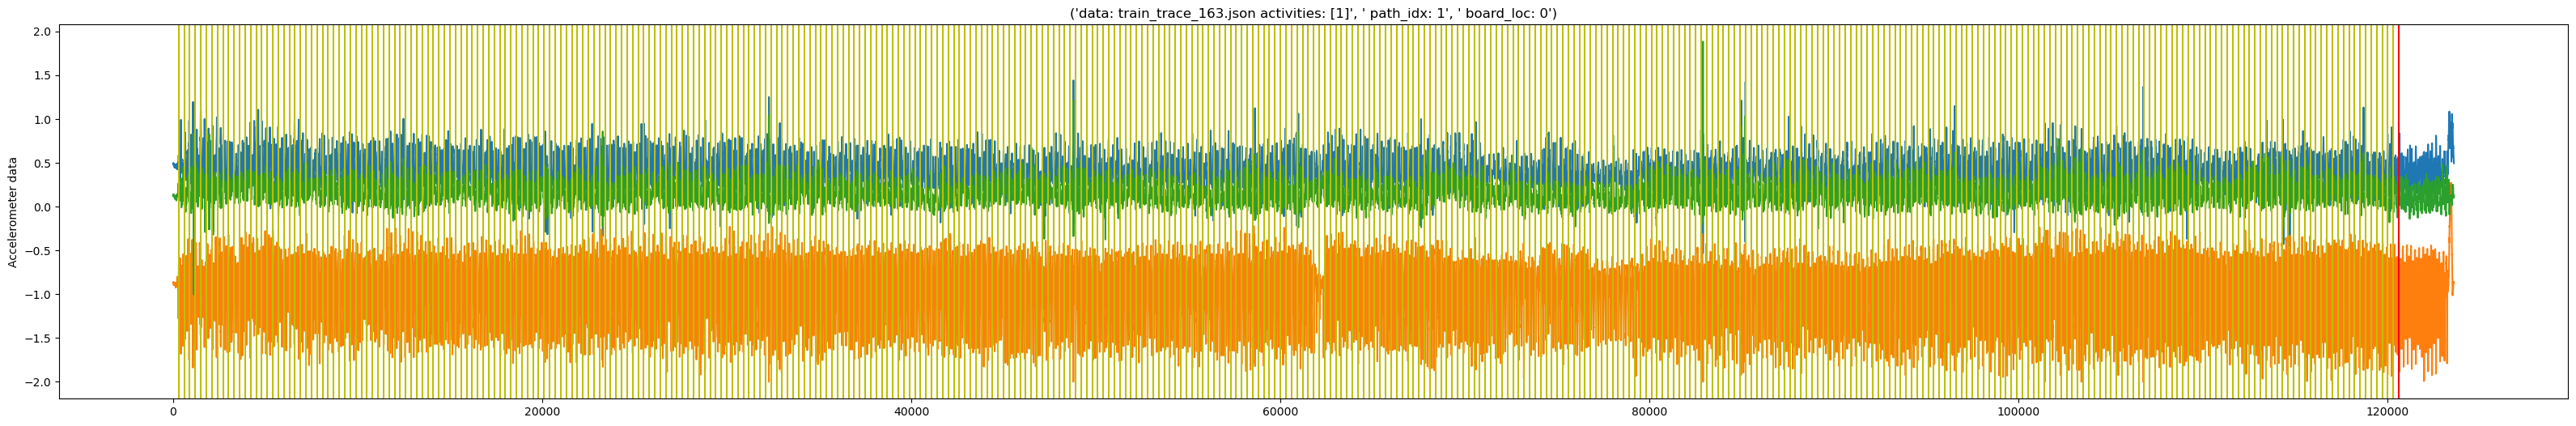

In [54]:
# generating labels
window_labels = np.zeros((data_win_count+1))
window_labels[0] = file_id+1
# window_labels[1:] = 1
window_labels[1:-1] = 3
# window_labels[round(24400*2/window_size):round(36700*2/window_size)] = 1


fig, ax = plt.subplots(1, 1, figsize=(40, 6), sharex=True)
ax.set_title(title)
ax.plot(trace.data['ax'].values)
ax.plot(trace.data['ay'].values)
ax.plot(trace.data['az'].values)
ax.set_ylabel('Accelerometer data')
color = ['r', 'b','g','y'] #0 red: standing, 1 blue: walking, 2 green: running, 3 yellow : cycling
for i, label in enumerate(window_labels[1:]):
    ax.axvline((i+1)*window_size/2, color = color[int(label)])

In [55]:
# check if trace already saved
with open(dir_labels+'action_labels_train.txt', 'r') as file:
    # Read the lines from the file
    lines = file.readlines()
    # Iterate through the lines
    saved_traces = []
    for line in lines:
        # Split the line into values, and convert them to floats or integers if needed
        values = [float(x) for x in line.strip().split(',')]
        saved_traces.append(values[0])
if (file_id+1) in saved_traces:
    print("trace ", file_id+1, " already exist")
elif(file_id+1 - saved_traces[-1]>1):
    # check data missing
    print("trace missing between: ", int(saved_traces[-1]), " and ", file_id+1)

else:
    # save label to txt file
    with open(dir_labels+'action_labels_train.txt', 'a') as f:
        f.write(','.join(map(str, window_labels)) + '\n')
    print("save trace: ", file_id+1)


trace missing between:  50  and  163
